In [331]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import warnings
import time
warnings.filterwarnings('ignore')

# Functions and classes

In [327]:
def check(x,n):
    val = 0
    if x > n:
        val = 1
    return val

class stats_met:
    """
    定义一个类，用来分类器的性能度量
    """
    def __init__(self, labels, scores):
        """
        :param labels:数组类型，真实的标签
        :param scores:数组类型，分类器的得分
        """
        self.labels = labels
        self.scores = scores
        self.TP, self.FP, self.FN, self.TN = self.get_confusion_matrix()
    
    def accuracy(self):
        """
        :return: 准确率
        """
        accuracy = (self.TP + self.TN) / (self.TP + self.FN + self.FP + self.TN)
        
        return accuracy
 
    def precision(self):
        """
        :return: 精准度
        """
        try:
            precision = self.TP / (self.TP + self.FP)
        except ZeroDivisionError:
            precision = np.nan
        
        return precision
 
    def recall(self):
        """
        :return: 召回率
        """
        try:
            recall = self.TP / (self.TP + self.FN)
        except ZeroDivisionError:
            recall = np.nan
        
        return recall
    
    def f_beta(self,beta):
        precision = self.precision()
        recall = self.recall()
        
        f_score = (1+beta**2)*((precision*recall/((beta**2)*precision+recall)))
        return f_score
 
    def get_confusion_matrix(self):
        """
        计算混淆矩阵
        :return:
        """
        tp, fp, fn, tn = 0., 0., 0., 0.
        for i in range(len(self.labels)):
            if self.labels[i] == 1 and self.scores[i] == 1:
                tp += 1
            elif self.labels[i] == 0 and self.scores[i] == 1:
                fp += 1
            elif self.labels[i] == 1 and self.scores[i] == 0:
                fn += 1
            else:
                tn += 1
        return [tp, fp, fn, tn]
    
    def get_eval_metrics(self):
        print("Precision = {:0.3f},Recall = {:0.3f}, F_score = {:0.3f}".format(self.precision(),self.recall(),self.f_beta(beta = 0.3)))
    
        
    
## Adjust graph spines
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 20))  # outward by 10 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
            
## function of getting the optimized paramters and score
def hypertuning_rscv(est,p_distr,nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,n_jobs=-1,scoring = 'roc_auc', n_iter=nbr_iter,cv=5)
    
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return(ht_params,ht_score)


def visualization(recall,precision,f_score,threshold):
    fig, ax = plt.subplots(1,1,figsize=(10,9))

    colors = [plt.cm.tab10(i/float(5)) for i in range(3)]
    
    thre_max = rows_xgb.loc[rows_xgb.F_beta == max(rows_xgb.F_beta),"threshold"].iloc[0]
    
    ax.plot(threshold,f_score,alpha = 0.3,color = colors[1],linewidth = "1")
    ax.scatter(threshold,f_score,alpha = 0.9,color = colors[1],s = 0.38)
    
    ax.axvline(thre_max, color="black", linestyle="dashed")

    ax.tick_params(axis= "x",direction = 'out',which='major', length=6.8,width=1, color='k',labelsize = 18)
    ax.tick_params(axis= "y",direction = 'out',which='major', length=6.8,width=1, color='k',labelsize = 18)
    ax.set_xticks([0.05*i for i in range(8,13)])
    ax.set_yticks([0.01*i for i in range(52,57)])
    ax.set_ylabel("F score",size = 25,labelpad=12)
    ax.set_xlabel("Threshold",size = 25,labelpad=12)
    #ax.set_title("ROC Curve",size = 30)

    ax.spines['left'].set_bounds(0.52,0.56)
    ax.spines['bottom'].set_bounds(0.4,0.6)
    ax.legend(fontsize = 25)

    adjust_spines(ax, ['left', 'bottom'])
    
### K fold target encoding for training test
class KFoldTargetEncoderTrain(BaseEstimator,TransformerMixin):

    def __init__(self, colnames,targetName,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = True, random_state=2019)



        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())

        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                                                                      self.targetName,
                                                                                      np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            

        return(X)
    
### K Fold target encoding for test set
class KFoldTargetEncoderTest(BaseEstimator, TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        mean =  self.train[[self.colNames,
                self.encodedName]].groupby(
                                self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
    
        return(X)
    
def model_train(cla,param_dist,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot = False,plot_fea = False):
    ## -------------------model training-------------------
    start_time = time.time()
    
    random_params, random_score = hypertuning_rscv(cla(),param_grid,nbr_iter,X_cv, y_cv)
    
    classifier_1 = cla(**random_params)
    classifier_1.fit(X_cv,y_cv)
    
    ## -------------------F score extraction-------------------

    prob_val = np.array(classifier_1.predict_proba(X_val)[:,1])

    interval = 0.2/10000
    threshold = [0.4 + i*interval for i in range(10001)]

    frame = pd.DataFrame()
    scores_cla = [1]*X_val.shape[0]
    
    for i in threshold:    
        scores_cla = [1 if j > i else 0 for j in prob_val]
        
        scores_val = list(scores_cla)
        label_val = list(target_val)
        
        cl = stats_met(label_val,scores_val)
        
        precision = cl.precision()
        
        recall = cl.recall()
        
        f_beta = cl.f_beta(beta = 0.3)

        frame_row = {"threshold":i,"Precision":precision,"Recall":recall,"F_beta":f_beta}
        frame = frame.append(frame_row,ignore_index=True)
    
    
    threshold_max = frame.loc[frame.F_beta == max(frame.F_beta),"threshold"].iloc[0]
    
    scores_val = [1 if j > threshold_max else 0 for j in prob_val]

    labels_val = list(target_val)
    
    val_metrics = stats_met(labels_val,scores_val)
    
    print("---The metric scores of the validation set is---")
    val_metrics.get_eval_metrics()
    
    if plot:
        threshold = frame["threshold"]
        f_score = frame["F_beta"]
        precision = frame["Precision"]
        recall = frame["Recall"]

        visualization(recall,precision,f_score,threshold)
    
    if plot_fea:
        fea_import = classifier_1.get_booster().get_score(importance_type='weight')

        impor_dat = pd.DataFrame({"features":list(fea_import.keys()),"feature_scores":list(fea_import.values())})
        impor_dat.sort_values("feature_scores",axis = 0,ascending = True,ignore_index=True,inplace = True)

        features = impor_dat["features"]
        feature_scores = impor_dat["feature_scores"]

        print('\n----------------Distribution of feature importance----------------\n')
        fig, ax = plt.subplots(1,1,figsize=(18,15))
        NUM_COLORS = 29
        cm = plt.get_cmap('gist_rainbow')
        colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

        ax.barh(features,feature_scores,color = colors)

        for p in ax.patches:
            val = '{}'.format(p.get_width())
            x = p.get_x() + p.get_width()
            y = p.get_y() + p.get_height()/8
            ax.annotate(val, (x, y),size = 20)

        ax.set_xticks([i for i in range(0,401,80)])
        ax.set_xticklabels([i for i in range(0,401,80)])

        ax.spines['bottom'].set_bounds(0,400)
        ax.spines['left'].set_bounds(0,7)

        ax.tick_params(axis= "both",direction = 'out',which='major', length=8,width=1, color='k',labelsize = 20)

        ax.set_yticks(features)
        ax.set_yticklabels(features)

        ax.set_ylabel("Features",size = 28,labelpad=12)
        ax.set_xlabel("Importance scores",size = 28,labelpad=12)
        adjust_spines(ax, ['left', 'bottom'])
    
    
    ## -------------------Training the whole dataset-------------------
    classifier_2 = cla(**random_params)
    classifier_2.fit(X_train,y_train)


    pred_test = classifier_2.predict_proba(X_test)[:,1]

    classifier_2.fit(X_train,y_train)

    sma_barr_scores_1 = list(pred_test) 
    sma_barr_scores_2 = [1 if k > threshold_max else 0 for k in sma_barr_scores_1]

    labels_test = list(target_test) ## delete expectancy
    scores_test = sma_barr_scores_2

    test_metrics = stats_met(labels_test,scores_test)

    print("---The metric scores of the test set is---")
    test_metrics.get_eval_metrics()

    print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
july = pd.read_csv('July.csv',encoding = "GBK")
aug = pd.read_csv('Aug.csv',encoding = "GBK")

In [21]:
barrel_tw = pd.read_csv('28_small.csv')
barrel_tw = barrel_tw[["city_code","l2_code"]]

In [22]:
dat = pd.read_csv('active_geek_number.csv')
dat.rename({"活跃牛人数":"active_geek_number"},axis = 1,inplace = True)
dat = dat.iloc[:,[1,2,3]].groupby(["l2_code","city_code"]).sum().reset_index()


## Extract the job barrel whose monthly active users were below 30 quantile
cut_off = dat.quantile(q = 0.3)[2]
job_barrel = dat.loc[dat["active_geek_number"]<cut_off,["l2_code","city_code"]].drop_duplicates().reset_index(drop = True)

In [23]:
job_barrel = pd.concat([job_barrel,barrel_tw],axis = 0).reset_index(drop = True).drop_duplicates()

# Data manipulation

## Dummy indicators for sales and deleted expected count:

In [24]:
july["del_exp_ind"] = july["del_exp_cnt"].apply(lambda x: check(x,0))
july["is_paid"] = july["sales"].apply(lambda x: check(x,0))

aug["del_exp_ind"] = aug["del_exp_cnt"].apply(lambda x: check(x,0))
aug["is_paid"] = aug["sales"].apply(lambda x: check(x,0))

## Preparation for training, validation, and test data set

In [285]:
july.iloc[:,[0,1,2,3,5]] = july.iloc[:,[0,1,2,3,5]].apply(lambda x: x.astype('category'))
aug.iloc[:,[0,1,2,3,5]] = aug.iloc[:,[0,1,2,3,5]].apply(lambda x: x.astype('category'))

july_1 = july.loc[july.is_poked == "poked",:].reset_index(drop = True)
july_1["city_l2"] = july_1["city_code"].astype("str") + "_" + july_1["l2_code"].astype("str")
aug["city_l2"] = aug["city_code"].astype("str") + "_" + aug["l2_code"].astype("str")

X_train = july_1.drop("is_paid",axis = 1)
target_train = july_1["is_paid"]
X_cv, X_val, target_cv, target_val = train_test_split(X_train,target_train, test_size=0.3, random_state=18)

In [286]:
dat_city_l2 = X_cv.iloc[:,[-1,-2]].groupby("city_l2").mean().reset_index()
dat_city_l2.rename(columns = {"del_exp_ind":"del_exp_ind_mean"},inplace = True)
dat_city_l2.sort_values("del_exp_ind_mean",axis = 0,ascending = True,ignore_index=True,inplace = True)

In [287]:
tier1 = dat_city_l2["del_exp_ind_mean"].quantile(q = 0.25)
tier2 = dat_city_l2["del_exp_ind_mean"].quantile(q = 0.5)
tier3 = dat_city_l2["del_exp_ind_mean"].quantile(q = 0.75)

In [288]:
dat_city_l2.loc[dat_city_l2.del_exp_ind_mean<=tier1,"tier"] = "tier1"
dat_city_l2.loc[(dat_city_l2.del_exp_ind_mean<=tier2)&(dat_city_l2.del_exp_ind_mean>tier1),"tier"] = "tier2"
dat_city_l2.loc[(dat_city_l2.del_exp_ind_mean<=tier3)&(dat_city_l2.del_exp_ind_mean>tier2),"tier"] = "tier3"
dat_city_l2.loc[dat_city_l2.del_exp_ind_mean>tier3,"tier"] = "tier4"

In [289]:
X_cv_up = X_cv.merge(dat_city_l2,"left",on = ["city_l2"])
X_val_up = X_val.merge(dat_city_l2,"left",on = ["city_l2"])

In [290]:
X_cv_up_new = X_cv_up.iloc[:,[8,9,10,11,12,13,14,17]]
X_val_up_new = X_val_up.iloc[:,[8,9,10,11,12,13,14,17]]

X_cv_up_new_1 = X_cv_up_new.drop("del_exp_ind",axis =1)
X_val_up_new_1 = X_val_up_new.drop("del_exp_ind",axis =1)

y_cv = X_cv_up["del_exp_ind"]
y_val = X_val_up["del_exp_ind"]

In [320]:
X_cv_up_new_enc = pd.get_dummies(X_cv_up_new_1,prefix=["tier"])
X_val_up_new_enc = pd.get_dummies(X_val_up_new_1,prefix=["tier"])

## Jul/Aug

In [292]:
dat_city_l2_2 = X_train.iloc[:,[-1,-2]].groupby("city_l2").mean().reset_index()

In [293]:
dat_city_l2_2.rename({"del_exp_ind":"del_exp_ind_mean"},axis = 1,inplace = True)

In [294]:
tier1 = dat_city_l2_2["del_exp_ind_mean"].quantile(q = 0.25)
tier2 = dat_city_l2_2["del_exp_ind_mean"].quantile(q = 0.5)
tier3 = dat_city_l2_2["del_exp_ind_mean"].quantile(q = 0.75)

In [295]:
dat_city_l2_2.loc[dat_city_l2_2.del_exp_ind_mean<=tier1,"tier"] = "tier1"
dat_city_l2_2.loc[(dat_city_l2_2.del_exp_ind_mean<=tier2)&(dat_city_l2_2.del_exp_ind_mean>tier1),"tier"] = "tier2"
dat_city_l2_2.loc[(dat_city_l2_2.del_exp_ind_mean<=tier3)&(dat_city_l2_2.del_exp_ind_mean>tier2),"tier"] = "tier3"
dat_city_l2_2.loc[dat_city_l2_2.del_exp_ind_mean>tier3,"tier"] = "tier4"

In [296]:
X_test = aug
test_small = X_test.merge(job_barrel,"right",on = ["city_code","l2_code"])
test_small = test_small.loc[test_small["is_poked"] == "poked",:].reset_index(drop = True)

test_small.drop("is_paid",axis = 1)
target_test = test_small["is_paid"]

In [305]:
X_train_up = X_train.merge(dat_city_l2_2,"left",on = ["city_l2"])
X_test_up = test_small.merge(dat_city_l2_2,"left",on = ["city_l2"])


X_train_up_new = X_train_up.iloc[:,[8,9,10,11,12,13,14,17]]
X_test_up_new = X_test_up.iloc[:,[8,9,10,11,12,13,14,18]]

X_train_up_new_1 = X_train_up_new.drop("del_exp_ind",axis =1)
X_test_up_new_1 = X_test_up_new.drop("del_exp_ind",axis = 1)

y_train = X_train_up_new["del_exp_ind"]
y_test_small = X_test_up_new["del_exp_ind"]

In [307]:
X_train_up_new_enc = pd.get_dummies(X_train_up_new_1,prefix=["tier"])
X_test_up_new_enc = pd.get_dummies(X_test_up_new_1,prefix=["tier"])

# Modeling

## Preparation for training and validation set

In [319]:
X_cv_up_new_1

,exposure_pv_14,exposure_pv_30,exposure_pv_90,exposure_pv_180,exposure_pv_365,exposure_pv_past_same,tier
0,0.0,0.0,0.0,0.0,0.0,0.0,tier2
1,0.0,0.0,0.0,109.0,805.0,967.0,tier3
2,1378.0,2096.0,4029.0,11558.0,19657.0,3882.0,tier2
3,1928.0,4301.0,13977.0,13977.0,13977.0,0.0,tier4
4,0.0,0.0,0.0,0.0,0.0,0.0,tier3
...,...,...,...,...,...,...,...
50282,0.0,0.0,0.0,0.0,2.0,1.0,tier4
50283,0.0,0.0,0.0,0.0,0.0,0.0,tier2
50284,0.0,0.0,0.0,0.0,0.0,0.0,tier2
50285,0.0,0.0,0.0,0.0,0.0,0.0,tier2


In [329]:
cla = XGBClassifier
param_grid ={
        "objective":['reg:logistic'],
        "booster":["gbtree"],
        'n_estimators': [500],
        'min_child_weight': list(range(3,9)), #****
        'max_depth': list(range(5,11)),       #****
        'gamma': [0,1,5,7,10],              #***
        'subsample': [round(0.1*i,2) for i in range(6,11)],    #**
        'colsample_bytree': [round(0.1*i,2) for i in range(6,11)],  #**
        'eta': [0.1,0.2], #*
        'reg_alpha':[0,0.01, 0.05]#*
}

nbr_iter = 18

## training set
X_train = X_train_up_new_enc
y_train = y_train
target_train = target_train

## sub training set
X_cv = X_cv_up_new_enc
y_cv = y_cv
target_cv = target_cv

## validation set
X_val = X_val_up_new_enc
y_val = y_val
target_val = target_val

## test set
X_test = X_test_up_new_enc
y_test = y_test_small
target_test = target_test

In [330]:
model_train(cla,param_grid,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot = False,plot_fea = False)

---The metric scores of the validation set is---
Precision = 0.572,Recall = 0.452, F_score = 0.560
---The metric scores of the test set is---
Precision = 0.465,Recall = 0.340, F_score = 0.452
--- 1077.5884478092194 seconds ---


In [332]:
cla = RandomForestClassifier
param_grid = {
    'criterion':['gini','entropy'],
    'min_samples_split':[2,3,5,6,8,10,12],
    'bootstrap': [True],
    'max_depth': [i for i in range(1,6)],
    'max_features': [i for i in range(6,12)],
    'min_samples_leaf': [3,4,5,6,7],
    'min_samples_split': [2,3,5,6],
    'n_estimators': [300,500,800]
    #"class_weight":["balanced","balanced_subsample"]
}

nbr_iter = 18

## training set
X_train = X_train_up_new_enc
y_train = y_train
target_train = target_train

## sub training set
X_cv = X_cv_up_new_enc
y_cv = y_cv
target_cv = target_cv

## validation set
X_val = X_val_up_new_enc
y_val = y_val
target_val = target_val

## test set
X_test = X_test_up_new_enc
y_test = y_test_small
target_test = target_test

In [335]:
model_train(cla,param_grid,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot = False,plot_fea = False)

---The metric scores of the validation set is---
Precision = 0.567,Recall = 0.492, F_score = 0.560
---The metric scores of the test set is---
Precision = 0.454,Recall = 0.402, F_score = 0.449
--- 311.31498098373413 seconds ---


In [499]:
july["exposure_pv_14"]

,city_code,l2_code,com_id,is_poked,sales,is_del,del_exp_cnt,olj_1,exposure_pv_14,exposure_pv_30,exposure_pv_90,exposure_pv_180,exposure_pv_365,exposure_pv_past_same,del_exp_ind,is_paid,expose_bin
0,101010100,120100,33961,unpoked,0.0,undeleted,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,101010100,120100,40849,unpoked,0.0,undeleted,0,0,1224.0,2132.0,2132.0,2132.0,2132.0,0.0,0,0,1
2,101010100,120100,81193,unpoked,0.0,undeleted,0,1,68.0,109.0,460.0,599.0,602.0,5.0,0,0,0
3,101010100,120100,166801,unpoked,0.0,undeleted,0,0,354.0,994.0,3084.0,4179.0,4187.0,11.0,0,0,1
4,101010100,120100,179593,unpoked,0.0,deleted,1037,5,5167.0,9969.0,66458.0,135135.0,339517.0,25775.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3982528,101310200,160100,817426,unpoked,0.0,undeleted,0,0,0.0,0.0,0.0,0.0,5736.0,1689.0,0,0,0
3982529,101310200,160100,10478338,unpoked,0.0,undeleted,0,0,0.0,6.0,378.0,758.0,1210.0,36.0,0,0,0
3982530,101310200,160100,25858258,unpoked,0.0,undeleted,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
3982531,101310200,160100,31065586,unpoked,0.0,undeleted,0,0,0.0,21.0,1228.0,4754.0,5179.0,0.0,0,0,0


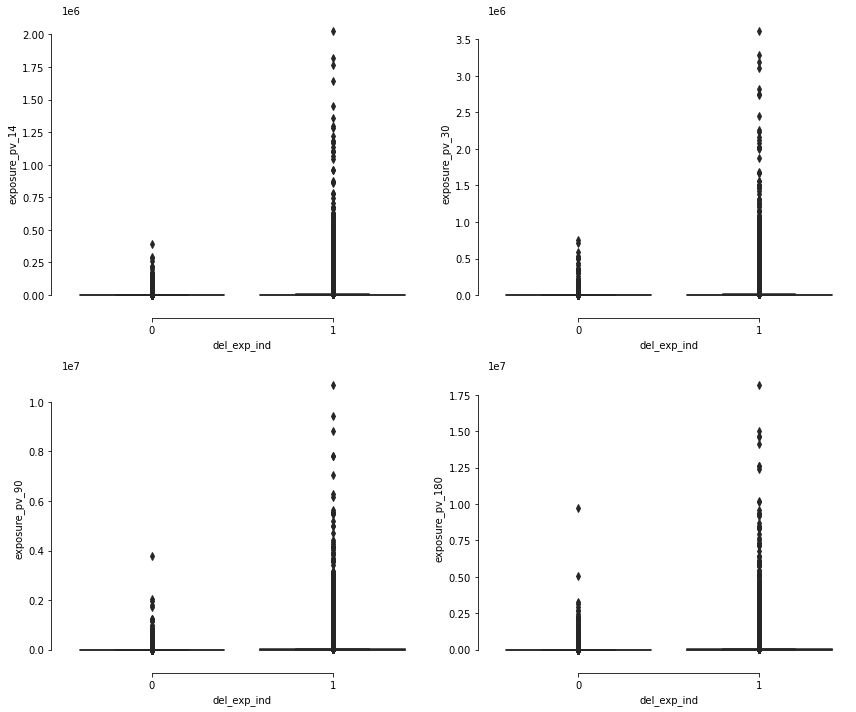

In [501]:
fig,axes = plt.subplots(2,2,figsize=(12,10))

sns.boxplot(x="del_exp_ind", y="exposure_pv_14",
             palette=["m", "g"],
            data=july,ax = axes[0,0])
sns.boxplot(x="del_exp_ind", y="exposure_pv_30",
             palette=["m", "g"],
            data=july,ax = axes[0,1])
sns.boxplot(x="del_exp_ind", y="exposure_pv_90",
             palette=["m", "g"],
            data=july,ax = axes[1,0])
sns.boxplot(x="del_exp_ind", y="exposure_pv_180",
             palette=["m", "g"],
            data=july,ax = axes[1,1])


sns.despine(offset=10, trim=True)

plt.tight_layout()